# Evaluation of Classification Models

Disclaimer: Material here is mostly based on the book by Aurelien Geron (2019) Hands-on ML 2nd Ed.

## Library Imports,  Basic Setup, Dataset

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", 'classification')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# MNIST dataset: if not previously downloaded and pickled, download and pickle, otherwise just load from pickle
import os, pickle
mnist_fname = 'mnist_874.pkl'
if os.path.exists(mnist_fname):
    with open(mnist_fname, 'rb') as handle:
        mnist = pickle.load(handle)
else:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    with open(mnist_fname, 'wb') as handle:
        pickle.dump(mnist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# the dataset is a dictionary, consisting of following fields:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape  # 70000 members of size 784 (28x28) pixels  

(70000, 784)

Saving figure some_digit_plot


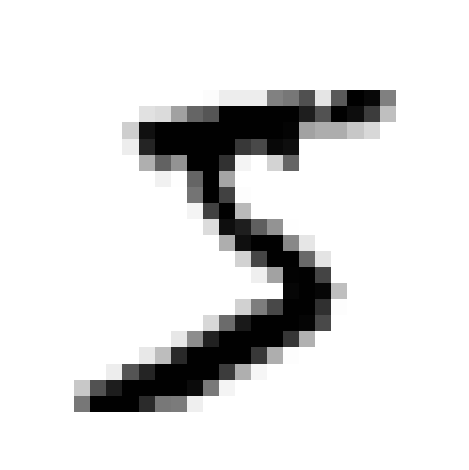

In [5]:
# One example member
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
# Label:
y[0]

'5'

In [7]:
# Convert the strings to integers
y = y.astype(np.uint8)

In [8]:
# A function to plot some members side by side
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


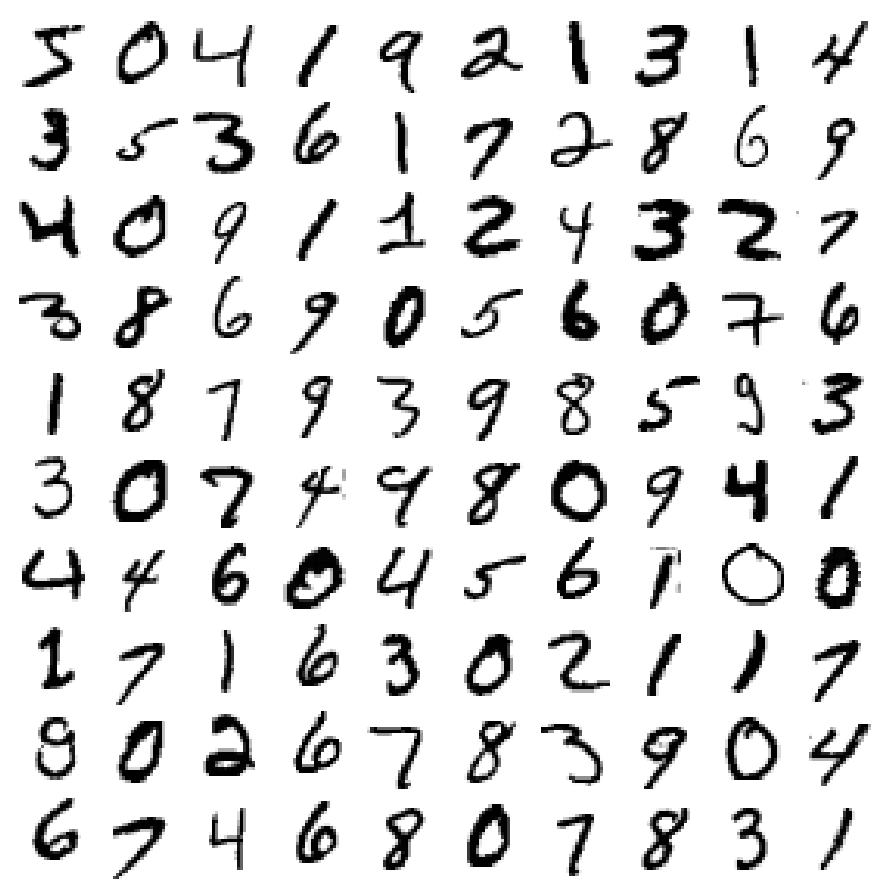

In [9]:
# Plot 100 example members
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Do the train-test splitting

In [10]:
# Train-Test split (60:10)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Clasifier

In [11]:
# Let's simplify the problem, and build a model that identifies 5's only.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# Let's pick a model and train it. Such as the Stochastic Gradient Descent (SGD) Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [42]:
# Let's browse some indecises and see how the predictions look like 
i = 0
print(f'y[i] = {y[i]}, prediction (is this a 5)? {sgd_clf.predict([X[i]])[0]}')

y[i] = 5, prediction (is this a 5)? True


## Performance Measures

Let's use cross_val_score() to evaluate the model using K-fold cross validation with 3 folds:

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Above 95 accuracy! Isn't this Amazing?

Before deciding we are done, let's try a dumb classifier that just returns False no matter what:

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

As before, let's use cross_val_score() to evaluate the model using K-fold cross validation with 3 folds:

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy. But thinking about it, this was to be expected, right?

### Confusion Matrix

Let's obtain predictions for the entire train split:

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Generate the confusion matrix for these predictions:

In [18]:
from sklearn.metrics import confusion_matrix

cm  = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Here a nicer display:

Saving figure confusion_matrix


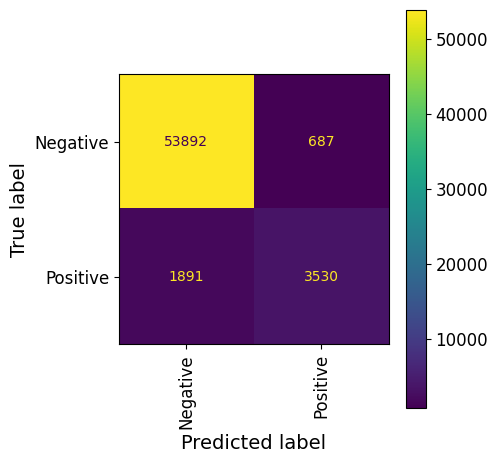

In [39]:
# import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative','Positive'])
disp.plot(ax=ax, xticks_rotation='vertical')
save_fig("confusion_matrix") 
plt.show()

### Precison and Recall, and the Trade-off

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

prec = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)
f1s = f1_score(y_train_5, y_train_pred)

print (f'Precision: {prec}; Recall: {rec}; F1-Score: {f1s}')

Precision: 0.8370879772350012; Recall: 0.6511713705958311; F1-Score: 0.7325171197343846


Visualising the dependency and choosing a threshold:

In [21]:
# use the cross_val_predict() to get the scores of all instances 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# use precision_recall_curve() to compute precision and recall for all thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [22]:
# A function to plot precision and recall vs thresholds
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])

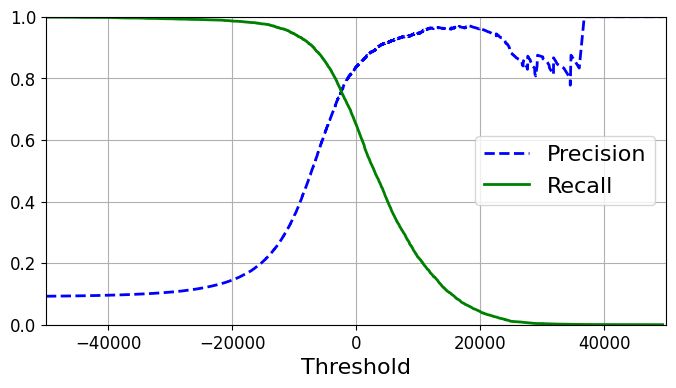

Saving figure precision_recall_vs_threshold_plot


<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
save_fig("precision_recall_vs_threshold_plot") 

Suppose we want a model that has at least 90% precision. What would be the corresponding recall?

Saving figure precision_recall_vs_threshold_plot_90precisionHL


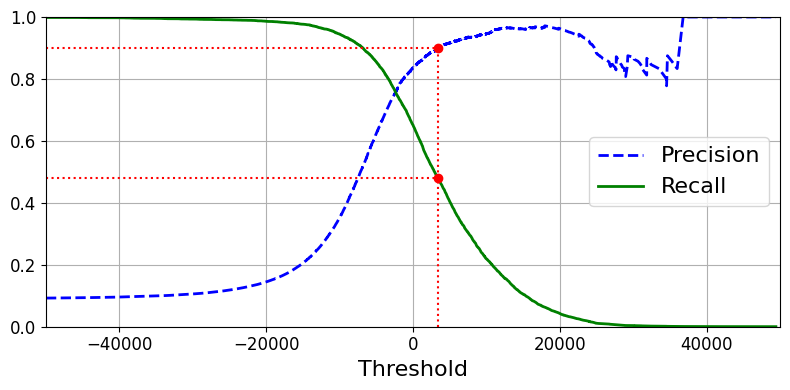

In [24]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot_90precisionHL")  
plt.show()

We can also plot the recall vs precision directly to analyze the relationship, and find a sweet spot:

Saving figure precision_vs_recall_plot


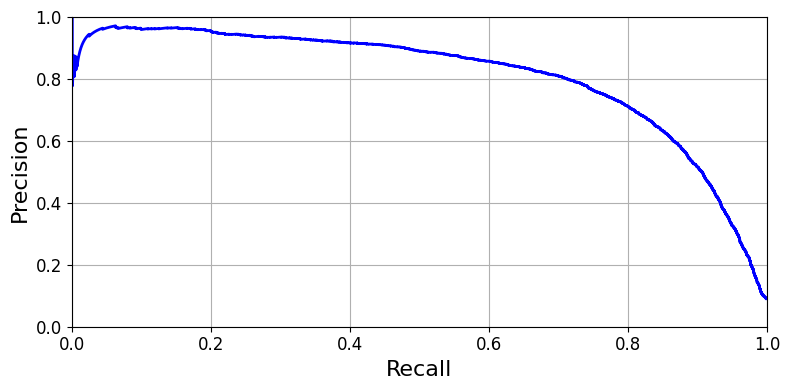

In [37]:
# A function to plot recall vs precision
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

# Produce the plot
plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Suppose we are aiming for 90% precision. Mark this on the curve:

Saving figure precision_vs_recall_plot_90precision


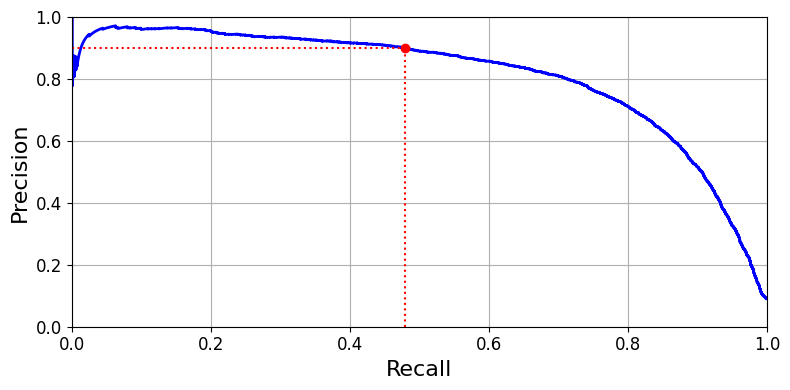

In [36]:
# Produce the plot
plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)

# Mark the 90% precision
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot_90precision")
plt.show()

### The ROC Curve

- The Receiver Operating Characacteristic (ROC) curve plots the TPR against FPR, hence showing the trade-off between the two. 
- The diagonal represents a random classifier, and a good classifier stays as far away from the line. 
- Therefore the area under the curve indicates the skill of the model. AUC = 1 : perfect model; AUC = 0.5 : random model. 

In [27]:
# Use the roc_curve() to compute the TPR and FPR for various threshold values
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Use the roc_auc_score() to compute area under the curve
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_5, y_scores)

In [28]:
# A function to plot fpr against tpr
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel('False Positive Rate (Fall-Out) (1 - Specificity)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

Saving figure roc_curve_plot


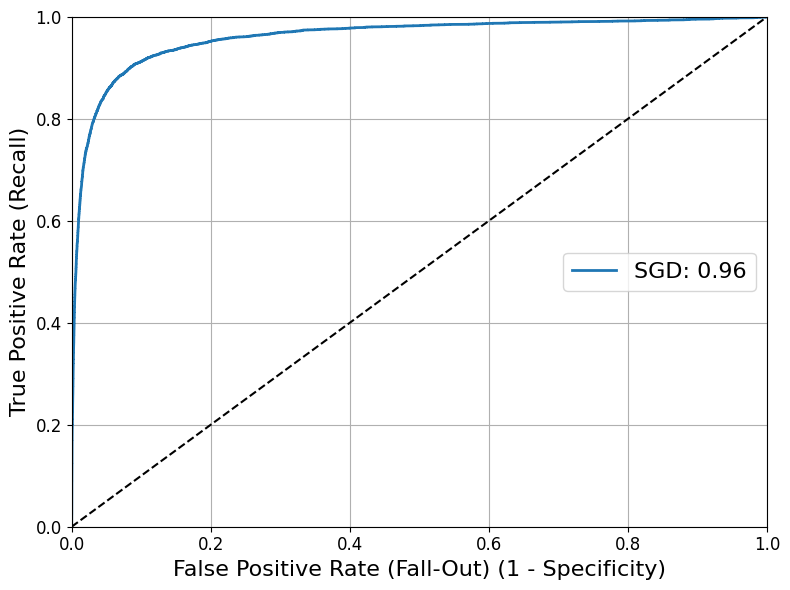

In [29]:
#Make the plot
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, label=f'SGD: {auc:.2f}')
save_fig("roc_curve_plot")                                   
plt.show()

Comparing Models Using ROC curves

Let's train a Random Forest Classifier Model for the same data set and compare it against the SGD model

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

auc_rf = roc_auc_score(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


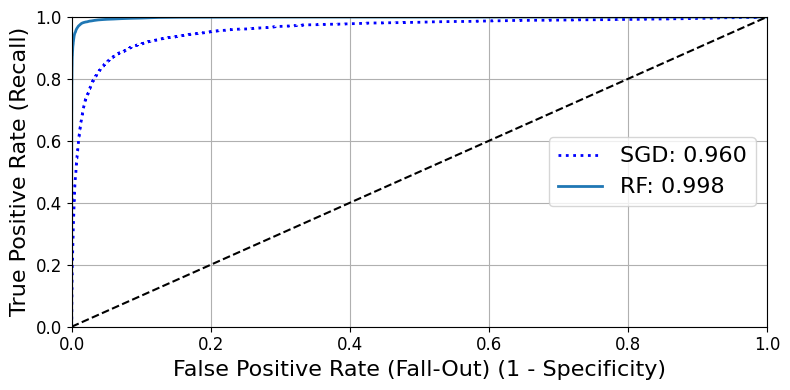

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, "b:", linewidth=2, label=f'SGD: {auc:.3f}')
plot_roc_curve(fpr_forest, tpr_forest, f'RF: {auc_rf:.3f}')
plt.grid(True)
plt.legend(loc="center right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()